<img src="images/ScDo-Bandeau_Lingua_Technologies.png" style="width: 100%;float:center;"/>

<h1 style="font-size:250%;text-align:center">Evolution over time of the</h1>
<h1 style="font-size:250%;text-align:center">COVID-19 (SARS-CoV-2) pandemic</h1>
<h4 style="font-size:150%;text-align:center">by Claude COULOMBE</h4>
<h5 style="font-size:100%;text-align:center">PhD, scientifique de données, consultant Lingua Technologies</h5>

<img src="images/ScDo-pandas_logo.png" width=400 />

To counter the anxiety of the COVID-19 pandemic, nothing better than taking action. So I prepared a IPython Notebook which is a pretext for a small data exploration exercise with Pandas.

### Python packages import

NumPy, Pandas, matplotlib and IPython / Jupyter libraries should have been installed.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline


## Data
### Open data repository COVID-19 (2019-nCoV) by Johns Hopkins University - CSSE


https://github.com/CSSEGISandData/COVID-19

<img src="" style="width: 100%;float:center;"/>

**NOTE**: The COVID-19 data contained in the DATA directory must be updated regularly to reflect changes over time.


### Reading and loading data

We are interested in the file `time_series_covid19_confirmed_global.csv` which contains the data on the confirmed cases of COVID-19

wget --no-check-certificate https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv?raw=True -O time_series_covid19_confirmed_global.csv

In [137]:
# Note - good practice of postfixing Dataframe by _df (Reminder: Python is not typed)
data_series_COVID19_df = pd.read_csv('DATA/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',sep=',')


## Data Exploration

In [138]:
data_series_COVID19_df.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,152411,152448,152448,152448,152583,152660,152722,152822,152960,152960
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,137597,138132,138790,139324,139721,140521,141365,142253,143174,144079
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,190078,190656,191171,191583,192089,192626,193171,193674,194186,194671
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,14981,14988,14988,14988,15002,15003,15014,15016,15025,15025
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,45325,45583,45817,45945,46076,46340,46539,46726,46929,47079


In [139]:
data_series_COVID19_df.tail()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
274,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,312611,323268,336707,348059,358456,369267,381363,392938,410366,422469
275,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,323582,324542,325404,326310,327634,329204,330821,332609,334472,335709
276,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,7407,7454,7487,7509,7539,7580,7625,7676,7711,7751
277,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,203553,203978,204337,204549,204651,204977,205107,205315,205704,205893
278,NaN,Zimbabwe,-19.015438,29.154857,0,0,0,0,0,0,...,121902,121902,122487,122652,123001,123320,123711,123986,124236,124367


### Display the global properties of the data table / DataFrame

Get the shape / dimensions, the underlying data structures and a statistical description of the numerical variables

In [140]:
data_series_COVID19_df.shape


(279, 589)

In [141]:
data_series_COVID19_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '8/19/21', '8/20/21', '8/21/21', '8/22/21', '8/23/21', '8/24/21',
       '8/25/21', '8/26/21', '8/27/21', '8/28/21'],
      dtype='object', length=589)

In [142]:
n_days = len(data_series_COVID19_df.columns) - 4
n_days


585

In [143]:
data_series_COVID19_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Columns: 589 entries, Province/State to 8/28/21
dtypes: float64(2), int64(585), object(2)
memory usage: 1.3+ MB


In [144]:
data_series_COVID19_df.describe()


,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
count,277.000000,277.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,...,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02
mean,20.305266,22.500100,1.996416,2.347670,3.372760,5.136201,7.591398,10.491039,19.992832,22.103943,...,7.526887e+05,7.557856e+05,7.577063e+05,7.592955e+05,7.617949e+05,7.641777e+05,7.667178e+05,7.692724e+05,7.722157e+05,7.741461e+05
std,25.206138,75.408236,26.637656,26.735265,33.284971,46.326447,64.742529,87.231432,214.047295,215.362435,...,3.331203e+06,3.346801e+06,3.351887e+06,3.355258e+06,3.366374e+06,3.374760e+06,3.383969e+06,3.393635e+06,3.409582e+06,3.414724e+06
min,-51.796300,-178.116500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.860416,-23.041800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.551500e+03,1.552000e+03,1.553000e+03,1.599000e+03,1.599000e+03,1.600000e+03,1.606000e+03,1.606500e+03,1.606500e+03,1.638000e+03
50%,21.521757,20.939400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.842800e+04,2.852400e+04,2.864700e+04,2.880200e+04,2.880200e+04,2.902200e+04,2.902200e+04,2.920900e+04,2.920900e+04,2.920900e+04
75%,40.463667,85.240100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.236035e+05,3.256860e+05,3.311295e+05,3.319735e+05,3.339655e+05,3.354760e+05,3.359695e+05,3.377195e+05,3.384730e+05,3.395300e+05
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,3.729414e+07,3.761360e+07,3.767631e+07,3.770981e+07,3.793964e+07,3.807489e+07,3.822303e+07,3.838436e+07,3.870729e+07,3.876036e+07


### Looking at data distribution and attributes

In [145]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.api.types import is_string_dtype, is_numeric_dtype 

MAX_SHOWN_ATTRIBUTES = 53

# For each attribute or column in a data array / DataFrame
# Create a box plot, an histogram or a list of possible values

def lookat_attribute_values_and_distribution(a_dataframe):
    for attribute in a_dataframe.columns:
        # Showing the attribute type
        print("-"*90)
        print("Attribute:",attribute,", Type:",a_dataframe.dtypes[attribute])
        # If it is a categorical attribute then list all possible values
        if is_string_dtype(a_dataframe[attribute]):
            unique_attributes = list(a_dataframe[attribute].unique())
            print("Number of unique attributes:",len(unique_attributes))
            if len(unique_attributes) > MAX_SHOWN_ATTRIBUTES:
                print("Display of " + str(MAX_SHOWN_ATTRIBUTES) + " first values:")
                print(unique_attributes[:MAX_SHOWN_ATTRIBUTES])
            else:
                print(unique_attributes)
                print("\nun_dataframe.groupby('"+attribute+"').size()\n",a_dataframe.groupby(attribute).size())
        if is_numeric_dtype(a_dataframe[attribute]):
            _ = a_dataframe.boxplot(attribute, figsize=(2, 3))
            plt.show()
            print()
            plt.close()
            _ = a_dataframe[attribute].plot(kind='hist',figsize=(2, 3))
            plt.show()
    print("-"*90)


In [146]:
# lookat_attribute_values_and_distribution(data_series_COVID19_df)


### Removal of "unnecessary" attributes

Since we are interested in the evolution of the number of patients over time, certain attributes (columns of the data table) are unnecessary or "useless" and burden our analysis.

Below is a list of attributes to remove:

In [147]:
attributes_to_remove = ["Lat","Long"]


Remove the "unnecessary" attributes with the `.drop ()` function

In [148]:
data_series_COVID19_df = data_series_COVID19_df.drop(attributes_to_remove,axis='columns')


In [149]:
data_series_COVID19_df.head()


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,152411,152448,152448,152448,152583,152660,152722,152822,152960,152960
1,NaN,Albania,0,0,0,0,0,0,0,0,...,137597,138132,138790,139324,139721,140521,141365,142253,143174,144079
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,190078,190656,191171,191583,192089,192626,193171,193674,194186,194671
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,14981,14988,14988,14988,15002,15003,15014,15016,15025,15025
4,NaN,Angola,0,0,0,0,0,0,0,0,...,45325,45583,45817,45945,46076,46340,46539,46726,46929,47079


### What are the different countries and / or states found in the data?

In [150]:
print(list(data_series_COVID19_df['Province/State'].unique()))


[nan, 'Australian Capital Territory', 'New South Wales', 'Northern Territory', 'Queensland', 'South Australia', 'Tasmania', 'Victoria', 'Western Australia', 'Alberta', 'British Columbia', 'Diamond Princess', 'Grand Princess', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island', 'Quebec', 'Repatriated Travellers', 'Saskatchewan', 'Yukon', 'Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Unknown', 'Xinjiang', 'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland', 'French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique', 'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy', 'Saint Pierre and Miquelon', 'St Martin'

In [151]:
print(list(data_series_COVID19_df['Country/Region'].unique()))


['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indones

#### For example, let's look at the data for different states and regions in the United States.

In [152]:
data_series_COVID19_df[data_series_COVID19_df['Country/Region']=="US"]


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
254,NaN,US,1,1,2,2,5,5,5,6,...,37294141,37613597,37676313,37709810,37939641,38074886,38223029,38384360,38707294,38760363


#### Now let's look at the data for the different Canadian provinces.

In [153]:
data_series_COVID19_df[data_series_COVID19_df['Country/Region']=="Canada"]


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
39,Alberta,Canada,0,0,0,0,0,0,0,0,...,242248,242997,242997,242997,244969,245598,246674,247786,248954,248954
40,British Columbia,Canada,0,0,0,0,0,0,1,1,...,158256,158919,158919,158919,160630,161271,161969,162693,163560,163560
41,Diamond Princess,Canada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,Grand Princess,Canada,0,0,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13
43,Manitoba,Canada,0,0,0,0,0,0,0,0,...,58134,58176,58176,58176,58283,58322,58425,58479,58506,58506
44,New Brunswick,Canada,0,0,0,0,0,0,0,0,...,2582,2614,2614,2614,2672,2687,2697,2705,2721,2721
45,Newfoundland and Labrador,Canada,0,0,0,0,0,0,0,0,...,1456,1458,1458,1458,1460,1460,1462,1462,1469,1469
46,Northwest Territories,Canada,0,0,0,0,0,0,0,0,...,259,328,328,328,351,358,368,395,400,400
47,Nova Scotia,Canada,0,0,0,0,0,0,0,0,...,5946,5956,5956,5956,5956,5982,5989,5990,5999,5999
48,Nunavut,Canada,0,0,0,0,0,0,0,0,...,657,657,657,657,657,657,657,657,657,657


### Creation of a specific additional entry for Quebec 

With an acute accent...

In [154]:
quebec_df = data_series_COVID19_df[(data_series_COVID19_df['Country/Region']=="Canada") & 
                                (data_series_COVID19_df['Province/State']=="Quebec")]

quebec_df.loc[51,'Country/Region'] = 'Québec'
quebec_df.loc[51,'Province/State'] = np.nan

data_series_COVID19_df = data_series_COVID19_df.append(quebec_df , ignore_index=True)
data_series_COVID19_df


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,152411,152448,152448,152448,152583,152660,152722,152822,152960,152960
1,NaN,Albania,0,0,0,0,0,0,0,0,...,137597,138132,138790,139324,139721,140521,141365,142253,143174,144079
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,190078,190656,191171,191583,192089,192626,193171,193674,194186,194671
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,14981,14988,14988,14988,15002,15003,15014,15016,15025,15025
4,NaN,Angola,0,0,0,0,0,0,0,0,...,45325,45583,45817,45945,46076,46340,46539,46726,46929,47079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,West Bank and Gaza,0,0,0,0,0,0,0,0,...,323582,324542,325404,326310,327634,329204,330821,332609,334472,335709
276,NaN,Yemen,0,0,0,0,0,0,0,0,...,7407,7454,7487,7509,7539,7580,7625,7676,7711,7751
277,NaN,Zambia,0,0,0,0,0,0,0,0,...,203553,203978,204337,204549,204651,204977,205107,205315,205704,205893
278,NaN,Zimbabwe,0,0,0,0,0,0,0,0,...,121902,121902,122487,122652,123001,123320,123711,123986,124236,124367


### Grouping of data from states and provinces
**Note**: To have a total by country, we will group together the states and provinces of the same country. Use of the `.groupby ()` and `.sum ()` functions. Also `.reset_index ()`

In [155]:
data_series_COVID19_df = data_series_COVID19_df.groupby(['Country/Region']).sum().reset_index()


Let's check that the grouping is done, with the data on Canada

In [156]:
data_series_COVID19_df[data_series_COVID19_df['Country/Region']=="Canada"]


,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
32,Canada,0,0,0,0,1,1,2,2,2,...,1470803,1473801,1474854,1476010,1481438,1483660,1487197,1490617,1494397,1495859


In [157]:
data_series_COVID19_df[data_series_COVID19_df['Country/Region']=="Québec"]


,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
143,Québec,0,0,0,0,0,0,0,0,0,...,383191,383718,384281,384744,385120,385465,386015,386618,387230,387834


In [158]:
# Correction of a data mistake - the total cases of Quebec for April 4, 2020 is 6997 not 6101
data_series_COVID19_df.loc[140,'4/4/20']=6997
# Correction of data December 25th and 26th 2020
data_series_COVID19_df.loc[140,'12/25/20']=185872+2235
data_series_COVID19_df.loc[140,'12/26/20']=185872+4492
# 2 808 nouveaux cas pour le 31 décembre, 1 986 pour le 1er janvier et de 2 869 pour le 2 janvier, 
data_series_COVID19_df.loc[140,'12/31/20']=199822+2808
data_series_COVID19_df.loc[140,'1/1/21']=199822+2808+1986
data_series_COVID19_df.loc[140,'1/2/21']=199822+2808+1986+2869
data_series_COVID19_df[data_series_COVID19_df['Country/Region']=="Québec"]


,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
143,Québec,0,0,0,0,0,0,0,0,0,...,383191,383718,384281,384744,385120,385465,386015,386618,387230,387834


## Data Visualization


### Visualization of the evolution of the number of sick people over time

We will visualize the evolution of the number of sick people over time by means of graphs and be able to compare between different countries in the world.

Let's take a look at our data table again.

In [159]:
data_series_COVID19_df


,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,152411,152448,152448,152448,152583,152660,152722,152822,152960,152960
1,Albania,0,0,0,0,0,0,0,0,0,...,137597,138132,138790,139324,139721,140521,141365,142253,143174,144079
2,Algeria,0,0,0,0,0,0,0,0,0,...,190078,190656,191171,191583,192089,192626,193171,193674,194186,194671
3,Andorra,0,0,0,0,0,0,0,0,0,...,14981,14988,14988,14988,15002,15003,15014,15016,15025,15025
4,Angola,0,0,0,0,0,0,0,0,0,...,45325,45583,45817,45945,46076,46340,46539,46726,46929,47079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Vietnam,0,2,2,2,2,2,2,2,2,...,312611,323268,336707,348059,358456,369267,381363,392938,410366,422469
192,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,323582,324542,325404,326310,327634,329204,330821,332609,334472,335709
193,Yemen,0,0,0,0,0,0,0,0,0,...,7407,7454,7487,7509,7539,7580,7625,7676,7711,7751
194,Zambia,0,0,0,0,0,0,0,0,0,...,203553,203978,204337,204549,204651,204977,205107,205315,205704,205893


In order to improve the reading of the data, we will reduce the time series by selecting every other day.

In [160]:
data_series_COVID19_df = data_series_COVID19_df[data_series_COVID19_df.columns[::2]]
data_series_COVID19_df

,Country/Region,1/23/20,1/25/20,1/27/20,1/29/20,1/31/20,2/2/20,2/4/20,2/6/20,2/8/20,...,8/9/21,8/11/21,8/13/21,8/15/21,8/17/21,8/19/21,8/21/21,8/23/21,8/25/21,8/27/21
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,150778,151291,151770,151770,152243,152411,152448,152583,152722,152960
1,Albania,0,0,0,0,0,0,0,0,0,...,133981,134487,135140,135947,136598,137597,138790,139721,141365,143174
2,Algeria,0,0,0,0,0,0,0,0,0,...,182368,184191,185902,187258,188663,190078,191171,192089,193171,194186
3,Andorra,0,0,0,0,0,0,0,0,0,...,14836,14891,14924,14924,14960,14981,14988,15002,15014,15025
4,Angola,0,0,0,0,0,0,0,0,0,...,43747,43998,44328,44617,44972,45325,45817,46076,46539,46929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Vietnam,2,2,2,2,2,6,8,10,13,...,224894,241543,255748,275044,293301,312611,336707,358456,381363,410366
192,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,317999,318435,319646,320034,321031,323582,325404,327634,330821,334472
193,Yemen,0,0,0,0,0,0,0,0,0,...,7187,7213,7256,7293,7347,7407,7487,7539,7625,7711
194,Zambia,0,0,0,0,0,0,0,0,0,...,200201,201342,201867,202261,202787,203553,204337,204651,205107,205704


### Creating a multi-curve graph (one curve per country)

1. We are going to create a simple visualization of the different day-to-day evolution curves of the number of “confirmed” sick people for different countries.


2. In order not to overload our graph, we will select certain countries which are more representative of the situation.

     2.1 Obviously Québec and Canada
    
     2.2 Countries that have applied strict sanitary, quarantine and social distancing measures: China, Japan, South Korea, and Singapore
    
     2.3 Countries which have either been slow to impose strict measures or whose health system has lacked resources: France, Italy, Iran, Spain, and the United States.

To facilitate visualization in a more compact graph, because of the large disparity in the number of sick people, we will use a logarithmic scale for the number of confirmed sick people.

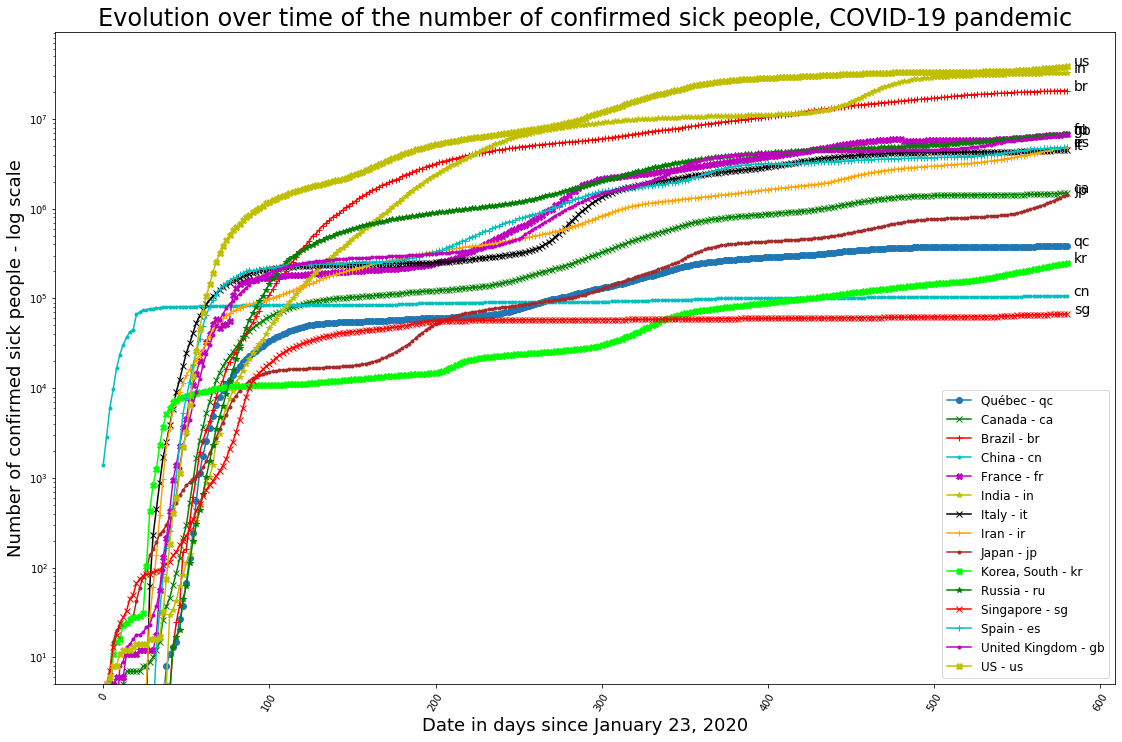

In [161]:
import itertools

golden_ratio = 1.618
height = 12
width = int(golden_ratio * height)
fig, ax = plt.subplots(figsize=(width,height))
# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
markers = itertools.cycle(('x', '+', '.', 'X', '*'))
colors_palette = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

countries = ['Québec', 'Canada', 'Brazil', 'China', 'France', 'India', 'Italy', 'Iran', 'Japan',
           'Korea, South', 'Russia', 'Singapore', 'Spain', 'United Kingdom', 'US']

countries_code = { 
    'Québec':'qc', 'Canada':'ca', 'Brazil':'br','China':'cn', 'France':'fr', 'India':'in',
    'Italy':'it', 'Iran':'ir','Japan':'jp','Korea, South':'kr', 'Russia':'ru','Singapore':'sg', 
    'Spain':'es', 'Sweden':'se','United Kingdom':'gb', 'US':'us'
}

for country in countries:
    if country == "Québec":
        a_marker = "o"
        a_color = "tab:blue"
    else:
        a_marker = next(markers)
        a_color = next(colors_palette)
    plt.plot(# Replace the date with the number of days since the start of the pandemic.
             # list(data_series_COVID19_df.columns[2:]), 
             [2*i for i in range(0,data_series_COVID19_df.shape[1]-2)],
             list(data_series_COVID19_df[data_series_COVID19_df['Country/Region']==country].iloc[0,2:]), 
             marker=a_marker, 
             color=a_color, 
             label=country+" - "+countries_code[country])
    label_y_pos = data_series_COVID19_df[data_series_COVID19_df['Country/Region']==country].iloc[0,-1]
    plt.text(n_days-1, label_y_pos, countries_code[country],fontsize=14)    
plt.legend(loc='best',fontsize=12)
xticks(rotation=60)
ax.set_yscale('log')
ylim(bottom=5)
# xlim(right=60)
plt.title(u'Evolution over time of the number of confirmed sick people, COVID-19 pandemic',fontsize=24)
plt.xlabel(u'Date in days since January 23, 2020',fontsize=18)
_ = plt.ylabel(u'Number of confirmed sick people - log scale',fontsize=18)
plt.savefig('images/Evolution-COVID19-LogScale.png')
plt.show()


#### To better appreciate the exponential growth

To better "see" the exponential growth of sick people, we comment the line `ax.set_yscale ('log')` which defines the logarithmic scale on the ordinate axis (i.e. vertical axis). So we come back to a linear scale.

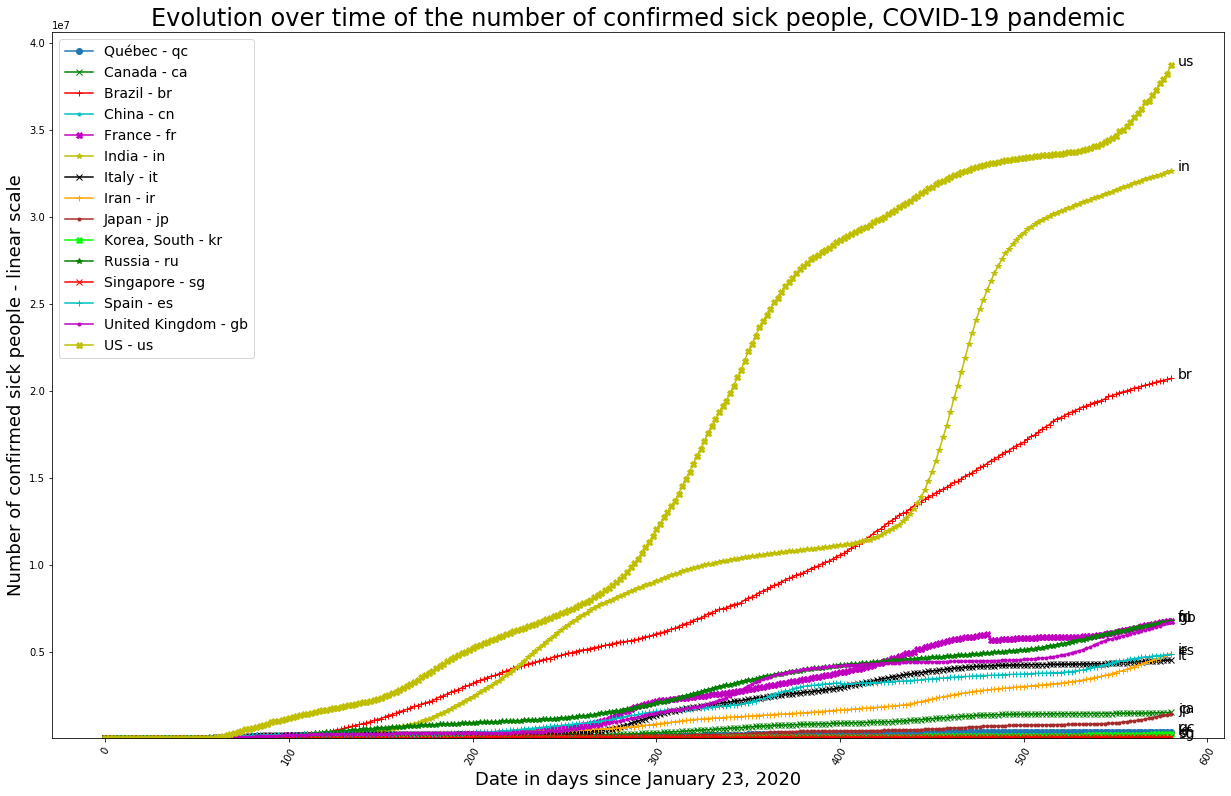

In [162]:
import itertools

golden_ratio = 1.618
height = 13
width = int(golden_ratio * height)
fig, ax = plt.subplots(figsize=(width,height))
# https://stackoverflow.com/questions/13091649/unique-plot-marker-for-each-plot-in-matplotlib
markers = itertools.cycle(('x', '+', '.', 'X', '*'))
colors_palette = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'orange', 'brown', 'lime'))

import matplotlib.colors as pltcol

countries = ['Québec', 'Canada', 'Brazil', 'China', 'France', 'India', 'Italy', 'Iran', 'Japan',
           'Korea, South', 'Russia', 'Singapore', 'Spain', 'United Kingdom', 'US']

countries_code = { 
    'Québec':'qc', 'Canada':'ca', 'Brazil':'br','China':'cn', 'France':'fr', 'India':'in',
    'Italy':'it', 'Iran':'ir','Japan':'jp','Korea, South':'kr', 'Russia':'ru','Singapore':'sg', 
    'Spain':'es', 'Sweden':'se','United Kingdom':'gb', 'US':'us'
}
 
for country in countries:
    if country == "Québec":
        a_marker = "o"
        a_color = "tab:blue"
    else:
        a_marker = next(markers)
        a_color = next(colors_palette)
    plt.plot(# Replace the date with the number of days since the start of the pandemic.
             # list(data_series_COVID19_df.columns[2:]), 
             [2*i for i in range(0,data_series_COVID19_df.shape[1]-2)], 
             list(data_series_COVID19_df[data_series_COVID19_df['Country/Region']==country].iloc[0,2:]), 
             marker=a_marker, 
             color=a_color, 
             label=country+" - "+countries_code[country])
    label_y_pos = data_series_COVID19_df[data_series_COVID19_df['Country/Region']==country].iloc[0,-1]
    plt.text(n_days-1, label_y_pos, countries_code[country],fontsize=14)    
plt.legend(loc='best',fontsize=14)
xticks(rotation=60)
# ax.set_yscale('log')
ylim(bottom=5)
#xlim(right=60)
plt.title(u'Evolution over time of the number of confirmed sick people, COVID-19 pandemic',fontsize=24)
plt.xlabel(u'Date in days since January 23, 2020',fontsize=18)
_ = plt.ylabel(u'Number of confirmed sick people - linear scale',fontsize=18)
plt.savefig('images/Evolution-COVID19-StdScale.png')
plt.show()


## Summary analysis

We find that countries, such as China, Japan, Taiwan, South Korea and Singapore, which have taken drastic quarantine and physical distancing (poorly named social distancing) measures, have succeeded in containing the increase in the number of sick people.

On the contrary, countries which have been slow to react or lacked resources like Italy, Iran, the United States, France or Spain have not yet succeeded in slowing down the increase in the number of sick people. For the moment Canada and Québec are in between but the trend of the last few days is raising a concern about a potential explosion. The Achilles' heel remains long-term care hospitals (CHSLD) and the residences for the elderly.

Hopeful sign, there has been a slight inflection in the rate of increase in Québec, the curve is flatting. It is important not to relax the hygiene and physical isolation measures because there is a risk of a rebound.

On the other hand, in the United States there is a resurgence of the epidemic during the month of June 2020 while Brazil does not even seen a decline.